## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from pathlib import Path

## Load dataset

In [8]:
path = Path().cwd()
data_file = path.parent / "Data" / "Actors.csv"

T = pd.read_csv(data_file, delimiter = ",")
# One hot encoding of actor
# This is unfortuanate necessary because sklearn only handles numerical features
T = pd.get_dummies(T,prefix=['Actor'])

print(T)

   Budget  IMDb  Actor_AP  Actor_NC  Actor_SJ
0     100   2.8     False      True     False
1      50   8.3     False     False      True
2     150   4.0     False     False      True
3      20   2.9     False      True     False
4      75   7.8      True     False     False
5     150   8.1      True     False     False
6     115   3.0      True     False     False
7     115   3.0     False      True     False


### 1. The first few exercises concern the fictitious movie dataset below. A real database with information on movies and TV-series is available in different formats from http://www.imdb.com/interfaces. The goal here is to predict the user rating of an upcoming movie as soon as the information on cast and budget is known, and to be able to explain in words why the movie will go straight to the Oscar's - or straight to oblivion.

| Observation  | Actor               | Budget ($ million)  | IMDB User Rating  |
|------        |------               |------               |------             |
| 1            | Nicholas Cage       | 100                 | 2.8               |
| 2            | Scarlett Johanson   |  50                 | 8.3               |
| 3            | Scarlett Johanson   | 150                 | 4.0               |
| 4            | Nicholas Cage       |  20                 | 2.9               |
| 5            | Al Pacino           |  75                 | 7.8               |
| 6            | Al Pacino           | 150                 | 8.1               |
| 7            | Al Pacino           | 115                 | 3.0               |
| 8            | Nicholas Cage       | 115                 | 3.0               |

> a) Is the described problem a classification or regression problem? Motivate your answer.

> b) Which input variables are categorical and which are continuous?

> c) For a categorical variable with k unique categories, what is the number of possible splits into two groups? Note that empty groups are not allowed, and that groupings are commutative in the sense that e.g. the split $\{1,2,3\},\{4,5\}$ is equal to the split $\{4,5\},\{1,3,2\}$.

We first make some simple examples and write down all possible splits to get a feeling on how the possible number of splits behave as k increase:

k=3:

{1},{2,3} - {2},{1,3} - {3},{1,2}   3 choose 1 = 3

k=4:

{1},{2,3,4} - {2},{1,3,4} - {3},{1,2,4} - {4},{1,2,3}  4 choose 1 = 4

{1,2},{3,4} - {1,3},{2,4} - {1,4},{2,3}   = 3

k=5:

{1},{2,3,4,5} - {2},{1,3,4,5} - {3},{1,2,4,5} - {4},{1,2,3,5} - {5},{1,2,3,4}  5 choose 1 = 5

{1,2},{3,4,5} - {1,3},{2,4,5} - {1,4},{2,3,5} - {1,5},{2,3,4} - {2,3},{1,4,5} - {2,4},{1,3,5} - {2,5},{1,3,4} - {3,4},{1,2,5} - {3,5},{1,2,4} - {4,5},{1,2,3}  5 choose 2 = 10

k=6:

{1},{2,3,4,5,6} - {2},{1,3,4,5,6} - {3},{1,2,4,5,6} - {4},{1,2,3,5,6} - {5},{1,2,3,4,6} - {6},{1,2,3,4,5}   6 choose 1 = 6

{1,2},{3,4,5,6} - {1,3},{2,4,5,6} - {1,4},{2,3,5,6} - {1,5},{2,3,4,6} - {1,6},{2,3,4,5} - {2,3},{1,4,5,6} - {2,4},{1,3,5,6} - {2,5},{1,3,4,6} - {2,6},{1,3,4,5} - {3,4},{1,2,5,6} - {3,5},{1,2,4,6} - {3,6},{1,2,4,5} - {4,5},{1,2,3,6} - {4,6},{1,2,3,5} - {5,6},{1,2,3,4}  6 choose 2 = 15

{1,2,3},{4,5,6} - {1,2,4},{3,5,6} - {1,2,5},{3,4,6} - {1,2,6},{3,4,5} - {1,3,4},{2,5,6} - {1,3,5},{2,4,6} - {1,3,6},{2,4,5} - {1,4,5},{2,3,6} - {1,4,6},{2,3,5} - {1,5,6},{2,3,4}   = 10

At this point we start to see a pattern. 
For odd k:

We sum together $\frac{k-1}{2} $ terms of the type "k choose r". We know a term of type "k choose r" can be calculated using the binomial coefficient, so we add together the $\frac{k-1}{2} $ lowest binomial terms starting at r=1 to find the possible number of splits.

$$ s(k) = \sum_{r=1}^{\frac{k-1}{2}} \left[ \begin{array}{c}  k \\ r \end{array} \right] $$

We can however simplify this further. Adding 1 is equivalent to a term of the type "k choose 0". Adding this term we will be summing half the terms in the sum of the binomial coefficients. Due to the symmetry of the binomial coefficients we therefore find

$$ s(k) + 1 = \sum_{r=0}^{\frac{k-1}{2}} \left[ \begin{array}{c}  k \\ r \end{array} \right]
    = \frac{1}{2} \sum_{r=0}^{\frac{k}{2}} \left[ \begin{array}{c}  k \\ r \end{array} \right]
    = \frac{1}{2} 2^k = 2^{k-1}
$$

For even k:

We again sum together $\frac{k}{2}-1$ terms of the type "k choose r" stating at r = 1, but then for $r = \frac{k}{2} $ we only use half of the possible combinations due to the commutative property.

$$ s(k) = \frac{1}{2} \left[ \begin{array}{c}  k \\ \frac{k}{2} \end{array} \right]  + \sum_{r=1}^{\frac{k}{2}-1} \left[ \begin{array}{c}  k \\ r \end{array} \right] $$

similarly to before we can add 1 and use the symmetry of the binomial coefficients to find

$$ s(k) + 1 = \frac{1}{2} \left[ \begin{array}{c} k \\ \frac{k}{2} \end{array} \right]  + \sum_{r=0}^{\frac{k}{2}-1} \left[ \begin{array}{c}  k \\ r \end{array} \right] = \frac{1}{2}\sum_{r=0}^{k} \left[ \begin{array}{c}  k \\ r \end{array} \right] = \frac{1}{2} 2^{k} = 2^{k-1} $$

Putting this together we have 

$$ s(k) = 2^{k-1}-1 $$

> d) What is the total number of splits to investigate at the root node for the movie dataset?

At the root node we can split either in the categorial "Actor" variable or continuous "Budget" variable. If we split the "Budget" variable we have a total of 8-1=7 possible splits to check. We have two pairs of observations which have the same "Budget", this further reduces the number of possible splits by 2 down to 5 possible splits. If we split the categorial "Actor" we know from exercise c that there is 3 possible splits. Therefore the total number of slipts to check in the root node is 8.

> e) Build a tree that predicts IMDb ratings.

In [5]:
# create a decisiontreeregressor/classifier
dtree=DecisionTreeRegressor()

# Fit the tree regressor/classifier
dtree.fit(T[['Actor_SJ', 'Actor_NC', 'Actor_AP', 'Budget']], T['IMDb'])

DecisionTreeRegressor()

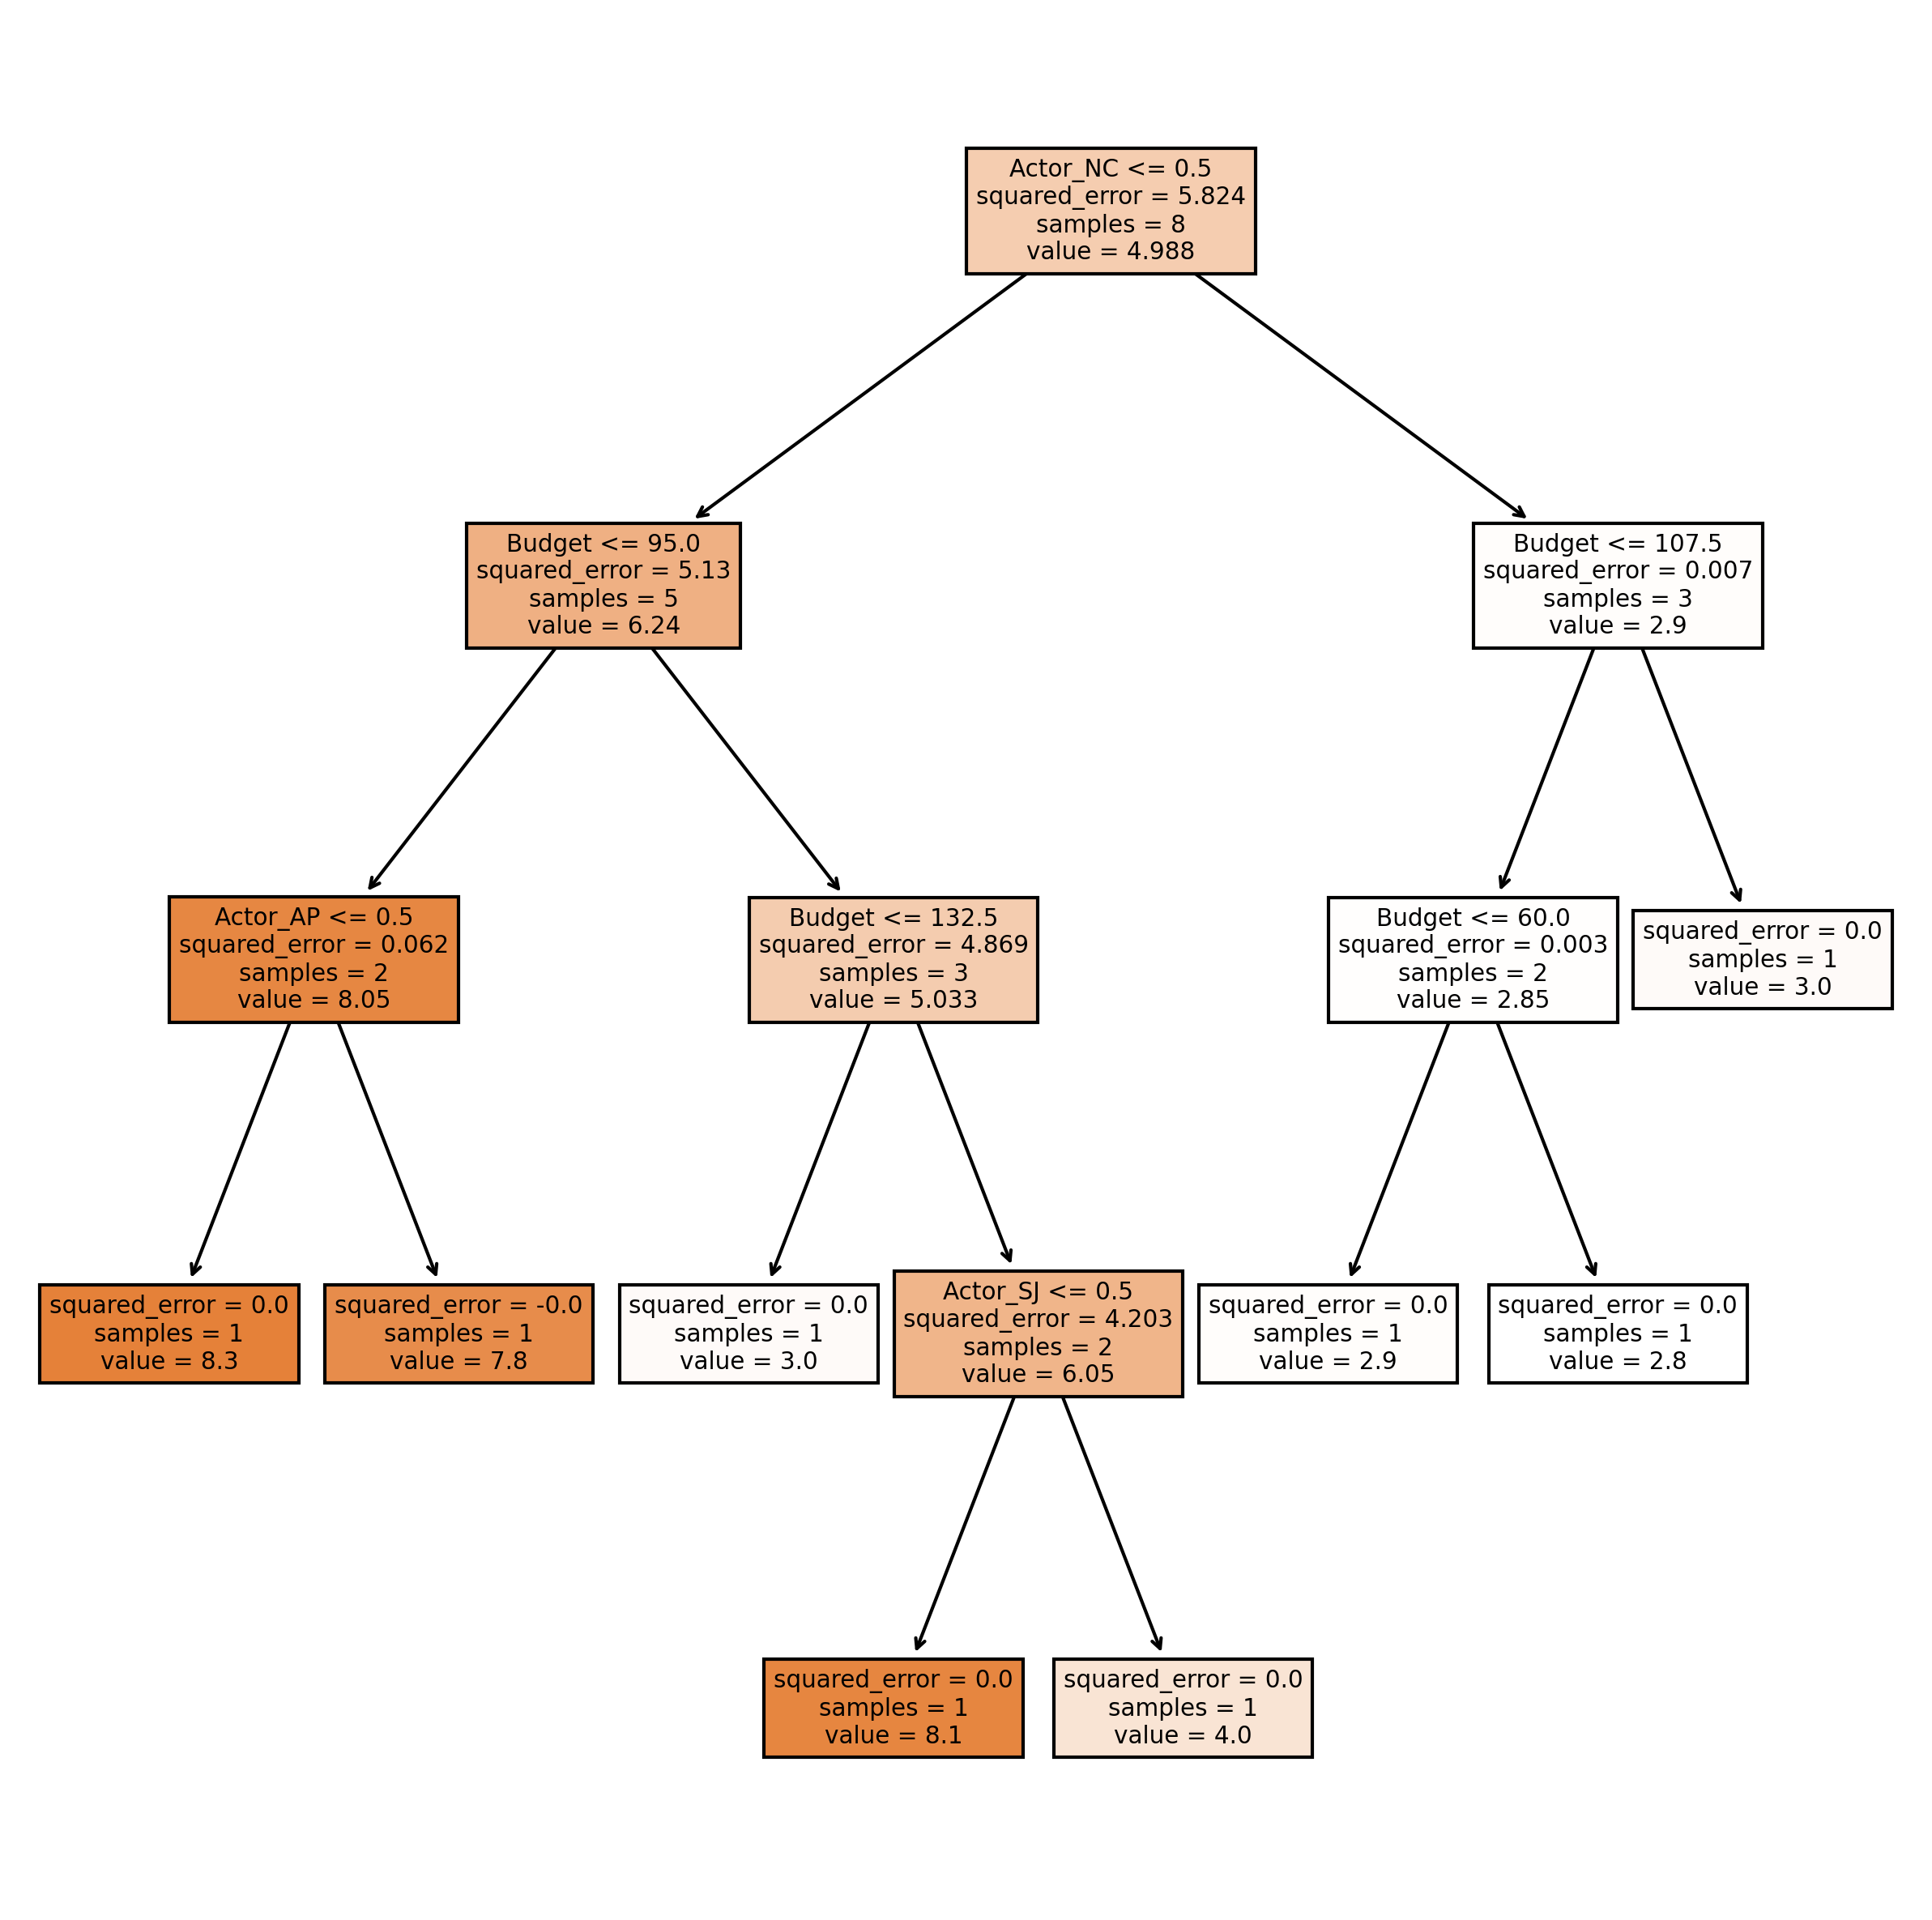

In [6]:
feature_names=['Actor_SJ', 'Actor_NC', 'Actor_AP', 'Budget']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(dtree,
               feature_names = feature_names,
               filled = True);